In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [7]:
df = pd.read_csv(r'Diabetes Dataset\Diabetes_and_LifeStyle_Dataset.csv')
df.head()

,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


In [8]:
#User Oriented Model Features

features = ['age', 'gender', 'ethnicity', 'smoking_status', \
        'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', \
        'sleep_hours_per_day', 'screen_time_hours_per_day', \
        'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', \
        'bmi', 'waist_to_hip_ratio']


# Select features and target variable
X = df.drop('diabetes_stage', axis=1)
y = df['diabetes_stage'] 

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=69)

# Normalize the features
inormalize = ['Age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', \
        'sleep_hours_per_day', 'screen_time_hours_per_day', \
        'bmi', 'waist_to_hip_ratio']

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[inormalize])
x_test_scaled = scaler.transform(x_test[inormalize])

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)


In [9]:
# Creating the Model

classes = ['No Diabetes', 'Pre Diabetes', 'Diabetes 1', 'Diabetes 2', 'Gestational']

def build_patient_model():
    model = models.Sequential([
        # Input layer
        layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Hidden layers
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        # Output layer
        layers.Dense(5, activation='softmax')
    ])
    return model

# Initialize Patient-side Model

patient_model = build_patient_model()

patient_model.compile(
    optimizer=Adam(learning_rate=0.05),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Implement Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model

history = patient_model.fit(
    x_train_scaled, y_train_encoded,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=(x_test_scaled, y_test_encoded),
    callbacks=[early_stopping]
)


Epoch 1/50


c:\Users\Sydney\Tensorflow\Keras-Diabetes\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2585/2585 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5904 - loss: 0.9002 - val_accuracy: 0.5916 - val_loss: 0.8950
Epoch 2/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5900 - loss: 0.8961 - val_accuracy: 0.5914 - val_loss: 0.8963
Epoch 3/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5888 - loss: 0.9001 - val_accuracy: 0.5995 - val_loss: 0.8874
Epoch 4/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5887 - loss: 0.8977 - val_accuracy: 0.5638 - val_loss: 0.8998
Epoch 5/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5883 - loss: 0.8988 - val_accuracy: 0.5979 - val_loss: 0.9028
Epoch 6/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.5905 - loss: 0.8970 - val_accuracy: 0.5760 - val_loss: 0.8904
Epoch 7/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5916 - loss: 0.8953 - val_accuracy: 0.5975 - val_loss: 0.8800
Epoch 8/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5896 - loss: 0.8945 - val_accurac

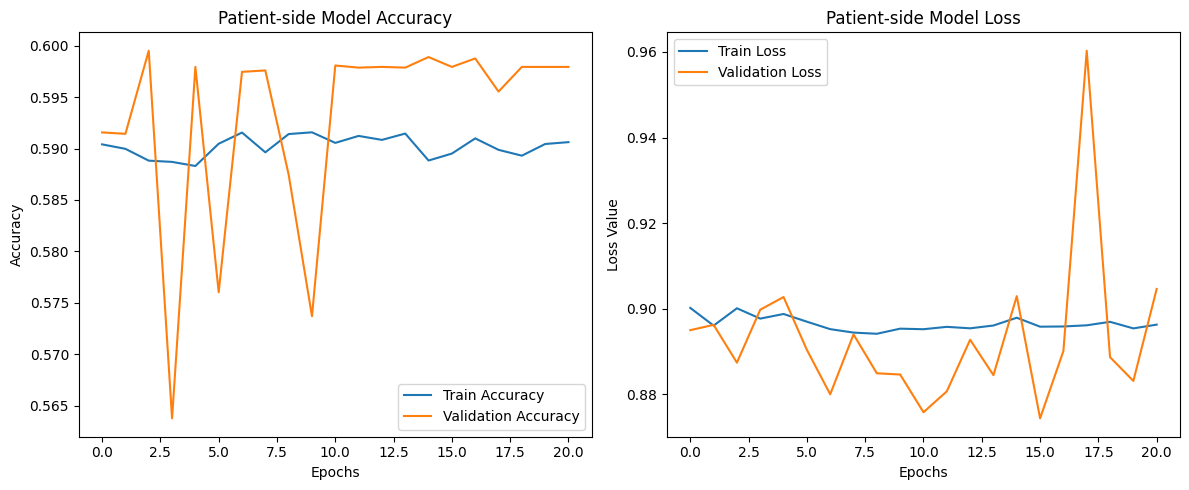

In [10]:
# Visualize Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Patient-side Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Patient-side Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.tight_layout()
plt.show()